# 使用Tensorflow构建VGG16模型实现猫狗识别

图像识别技术可以识别出图像或者视频中的物体类别。本实验基于猫狗数据集，使用Keras手动搭建一个经典的VGG16卷积神经网络，训练一个猫狗分类模型。

## 数据集

猫狗识别数据集，猫和狗各12500张图片，图片名称中含有类别名称（cat和dog）。我们会根据图片名称中包含的类别名称（cat或dog）给图片打标签，狗的标签打成1，猫的标签打成0。

### 依赖安装

In [2]:
# !pip install --upgrade keras_applications==1.0.6 keras==2.2.4

### 导入依赖库

In [1]:
import numpy as np
from mindspore import Tensor, nn, Model 
from mindspore.train.callback import LossMonitor, CheckpointConfig, ModelCheckpoint

In [2]:
import os, cv2, random

### 下载数据集

下载数据压缩包，解压，然后清理压缩包。

In [5]:
# !wget https://modelarts-labs-bj4.obs.cn-north-4.myhuaweicloud.com/notebook/DL_image_recognition/image_recognition.tar.gz

In [3]:
import os
if not os.path.exists('./data'):
    !tar xf ./image_recognition.tar.gz
    !rm -f ./image_recognition.tar.gz

### 读取数据集

读取数据集，并把图像resize到 128 * 128 大小。

In [4]:
DATA_DIR = './data/' # 数据集路径
from tqdm.notebook import tqdm
# 目标缩放尺寸
ROWS = 128
COLS = 128
CHANNELS = 3

image_file_names = [DATA_DIR+i for i in os.listdir(DATA_DIR)] 
dogs = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'dog' in i]
cats = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'cat' in i]

# 数据洗牌
random.shuffle(image_file_names)

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) # 彩色模式读取图像
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(image_file_names):
    count = len(image_file_names)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
    
    for i, image_file in enumerate(tqdm(image_file_names)):
        image = read_image(image_file)
        data[i] = image
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

# 读取图片至内存
images = prep_data(image_file_names)

  0%|          | 0/25000 [00:00<?, ?it/s]

Processed 0 of 25000
Processed 1000 of 25000
Processed 2000 of 25000
Processed 3000 of 25000
Processed 4000 of 25000
Processed 5000 of 25000
Processed 6000 of 25000
Processed 7000 of 25000
Processed 8000 of 25000
Processed 9000 of 25000
Processed 10000 of 25000
Processed 11000 of 25000
Processed 12000 of 25000
Processed 13000 of 25000
Processed 14000 of 25000
Processed 15000 of 25000
Processed 16000 of 25000
Processed 17000 of 25000
Processed 18000 of 25000
Processed 19000 of 25000
Processed 20000 of 25000
Processed 21000 of 25000
Processed 22000 of 25000
Processed 23000 of 25000
Processed 24000 of 25000


### 给图片打标签

我们根据图片名称包含的字符串给图片打标签。我们用0表示cat，1表示dog。

In [5]:
num_train_samples = len(image_file_names)
num_classes = 2 # 类别数是2
labels = []

index = 0
for filename in image_file_names:
    if 'dog' in filename:
        labels.append(1)
    elif 'cat' in filename:
        labels.append(0)
    

In [6]:
type(labels)

list

In [7]:
# 把类别标签转换为onehot编码
# labels = np_utils.to_categorical(labels, num_classes)
from mindspore.ops import operations as P

one_hot = P.OneHot()
# labels = one_hot(mindspore.Tensor(labels), num_classes)

In [9]:
import mindspore

In [10]:
depth = 2
on_value = Tensor(np.array([1.0]), mindspore.float32)
off_value = Tensor(np.array([0.0]), mindspore.float32)
result = one_hot(mindspore.Tensor(labels), depth, on_value, off_value)

In [11]:
labels=mindspore.Tensor.asnumpy(result)

In [12]:
labels

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### 切分数据集

（train_data，train_label）是训练数据，（test_data，test_label）是测试数据。测试数据占25%。

In [13]:
import mindspore

In [14]:
import mindspore.dataset as ds

train_data = ds.NumpySlicesDataset(images)
train_label = ds.NumpySlicesDataset(labels)

train_data, test_data = train_data.split([0.75, 0.25], randomize=True)
train_label, test_label = train_label.split([0.75, 0.25], randomize=True)

[WARNING] ME(1342:139969149526208,MainProcess):2023-05-03-21:06:56.675.547 [mindspore/dataset/engine/datasets.py:2309] Dataset is shuffled before split.
[WARNING] ME(1342:139969149526208,MainProcess):2023-05-03-21:06:56.677.973 [mindspore/dataset/engine/datasets.py:2309] Dataset is shuffled before split.


### 查看猫狗的样本图片

这些图片是经过尺寸调整后的图片

In [15]:
import numpy as np
import matplotlib.pyplot as plt 

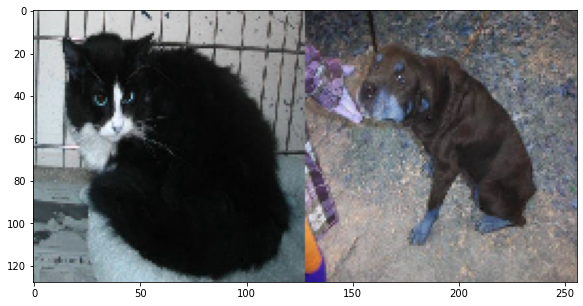

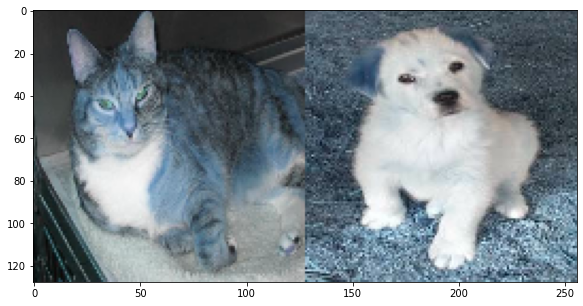

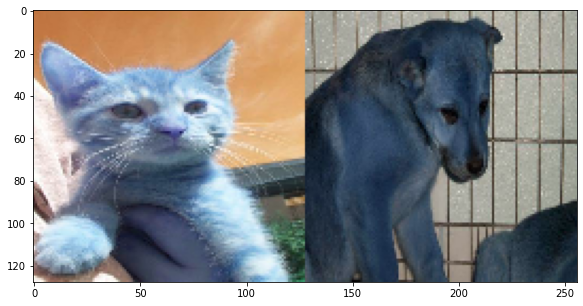

In [16]:
def show_cats_and_dogs(idx):
    cat = read_image(cats[idx])
    dog = read_image(dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,3):
    show_cats_and_dogs(idx)

### 构建神经网络

Keras是一个非常简单易用的，适合新手入门的深度学习引擎。接下来，我们使用Keras搭建一个VGG16卷积神经网络。

#### 设置超参

In [17]:
batch_size = 32 # 批大小
learning_rate = 1e-5 # 设置学习率为1e-5

#### 设置优化器

In [40]:
optimizer = Adam(lr=learning_rate) # 优化器使用 Adam 

NameError: name 'Adam' is not defined

In [ ]:
import mindspore.nn as nn
from mindspore import Model

class MyModel(nn.Cell):
    def __init__(self):
        super(MyModel, self).__init__()
        self.base_model = nn.VGG16(include_top=False, weights=None, input_shape=(ROWS, COLS, CHANNELS), pooling='avg')
        self.fc = nn.Dense(2)

    def construct(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        return x

model = Model(MyModel(), loss_fn=nn.loss.SoftmaxCrossEntropyWithLogits(), optimizer=nn.Adam(lr=learning_rate), metrics={'acc'})
model.summary()

In [57]:
# pip install git+https://gitee.com/mindspore/hub.git

In [58]:
# !pip install --upgrade mindspore

In [18]:
import mindspore_hub as mshub
from mindspore import context

context.set_context(mode=context.GRAPH_MODE,
                    device_target="CPU",
                    device_id=0)

model = "mindspore/1.9/vgg16_imagenet2012"
vgg16 = mshub.load(model)
# vgg16.set_train(False)

[WARNING] ME(1342:139969149526208,MainProcess):2023-05-03-21:07:08.553.885 [mindspore_hub/__init__.py:58] Current version of MindSpore is not compatible with MindSpore Hub. Some functions might not work or even raise error. Please install MindSpore version == 2.0.0. For more details about dependency setting, please check the instructions at MindSpore official website https://www.mindspore.cn/install or check the README.md at https://gitee.com/mindspore/hub
[WARNING] ME(1342:139969149526208,MainProcess):2023-05-03-21:07:08.554.650 [mindspore_hub/__init__.py:65] Please pay attention to the above warning, countdonw: 3
[WARNING] ME(1342:139969149526208,MainProcess):2023-05-03-21:07:09.556.912 [mindspore_hub/__init__.py:65] Please pay attention to the above warning, countdonw: 2
[WARNING] ME(1342:139969149526208,MainProcess):2023-05-03-21:07:10.558.971 [mindspore_hub/__init__.py:65] Please pay attention to the above warning, countdonw: 1


Checking /root/.mscache/mindspore/1.9/vgg16_imagenet2012.md...Passed!
{'device_target': 'device where the code will be implemented.', 'dataset': "choices in ['cifar10', 'imagenet2012']", 'data_dir': 'data dir', 'pre_trained': 'model_path, local pretrained model to load', 'lr_gamma': 'decrease lr by a factor of exponential lr_scheduler', 'eta_min': 'eta_min in cosine_annealing scheduler', 'T_max': 'T-max in cosine_annealing scheduler', 'log_interval': 'logging interval', 'ckpt_path': 'checkpoint save location', 'ckpt_interval': 'ckpt_interval', 'is_save_on_master': 'save ckpt on master or all rank', 'is_distributed': 'if multi device', 'pad_mode': "choices in ['same', 'pad']", 'per_batch_size': 'batch size for per npu', 'graph_ckpt': 'graph ckpt or feed ckpt', 'log_path': 'path to save log', 'result_dir': 'result files path.', 'label_dir': 'image file path.', 'dataset_name': "choices in ['cifar10', 'imagenet2012']", 'result_path': 'result path', 'ckpt_file': 'vgg16 ckpt file.', 'file_na

TypeError: unsupported operand type(s) for //: 'str' and 'int'

In [42]:
# optimizer = nn.Adam(lr=learning_rate) # 优化器使用 Adam 
# loss_fn=nn.loss.SoftmaxCrossEntropyWithLogits() # loss 函数使用交叉熵

class MyModel(nn.Cell):
    def __init__(self):
        super(MyModel, self).__init__()
        self.base_model = nn.VGG16(include_top=False, weights=None, input_shape=(ROWS, COLS, CHANNELS), pooling='avg')
        self.fc = nn.Dense(2)

    def construct(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        return x

model = Model(MyModel(), loss_fn=nn.loss.SoftmaxCrossEntropyWithLogits(), optimizer=nn.Adam(lr=learning_rate), metrics={'acc'})
model.summary()

AttributeError: module 'mindspore.nn' has no attribute 'VGG16'

### 模型结构概览

可以查看到刚刚搭建的神经网络结构的详情。

In [ ]:
model.summary()

### 模型训练

在模型训练过程中，为了防止过拟合，我们使用了early stopping策略，当val_loss在连续3个epoch不再减少的情况下，就停止训练。

本案例训练15轮，大概耗费10分钟。

可以看到训练日志输出，其中会打印Loss（损失函数）和acc（精确度）信息。

In [ ]:
epochs = 15 # 训练轮数

# early stopping策略
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')   

def run_train():
    
    # 开始训练
    history = model.fit(
        train_data, 
        train_label, 
        batch_size=batch_size, 
        epochs=epochs,
        validation_split=0.2,  # 训练数据中，抽取20%的数据作为验证数据
        verbose=1,
        shuffle=True,
        callbacks=[early_stopping]) 
    return history

history = run_train()

### 保存模型

训练好的模型可以保存起来，永久使用。

In [ ]:
OUTPUT = 'output'

if not os.path.exists(OUTPUT):
    os.mkdir(OUTPUT)

model.save(os.path.join(OUTPUT, 'model.h5'))

### 可视化训练过程

将Loss随epoch的变化趋势使用折线图展示

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

将accurary随epoch的变化趋势使用折线图展示

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.xlabel('Epochs')
plt.ylabel('acc')
plt.title('VGG-16 acc Trend')
plt.plot(acc, 'blue', label='Training acc')
plt.plot(val_acc, 'green', label='Validation acc')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

### 样本数据预测

预测测试集

In [ ]:
predictions = model.predict(test_data, verbose=0)

直观展示10个样本数据的预测结果

In [ ]:
for i in range(0,10):
    p = predictions[i]
    
    if round(p[1]) == 1: 
        print('I am {:.2%} sure this is a Dog'.format(p[1]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1 - p[1]))
        
    plt.imshow(test_data[i])
    plt.show()

### 评估模型准确度

通过测试集的预测结果，计算模型的准确度。

In [ ]:
predictions_test_array = []
test_label_array = []

# 将onehot编码的数据进行格式转换
for p in predictions:
    if round(p[1]) == 1:
        predictions_test_array.append(1)
    else:
        predictions_test_array.append(0)
        
for t in test_label:
    if int(t[1]) == 1:
        test_label_array.append(1)
    else:
        test_label_array.append(0)
        
acc = accuracy_score(test_label_array, predictions_test_array)

print('训练得到的猫狗识别模型的准确度是：%f' % acc)

## 总结

本Notebook使用Keras搭建了一个VGG16神经网络，并使用猫狗数据集训练了一个猫狗识别模型。